In [1]:
#-------Import Dependencies-------#
import pandas as pd
import os,shutil,math
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import ImageDraw
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg19 import VGG19,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

Using TensorFlow backend.


In [2]:
#-----In case you want to use a learning rate scheduler from keras this is a good step decay function to play around with-----#
def step_decay(epoch):
    initial_lrate=0.1
    drop=0.6
    epochs_drop = 3.0
    lrate= initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

In [3]:
#----Custom function to visualize the training of the model------#
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [4]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "histopathologic_cancer_detector.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
ROC_PLOT_FILE = "roc.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"
INPUT_DIR = '../input/'
SAMPLE_COUNT = 60000
TESTING_BATCH_SIZE = 5000

In [5]:
training_dir = INPUT_DIR + 'train/'

df = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})

df['id'] = df.path.map(lambda x: x.split('/')[3].split('.')[0])

labels = pd.read_csv(INPUT_DIR + 'train_labels.csv')

df = df.merge(labels,on='id')

negative_values = df[df.label == 0].sample(SAMPLE_COUNT)
positive_values = df[df.label == 1].sample(SAMPLE_COUNT)

df = pd.concat([negative_values,positive_values]).reset_index()

df = df[['path','id','label']]
df['image'] = df['path'].map(imread)

In [6]:
train_path = '../training'
val_path = '../validation'

for directory in [train_path,val_path]:
    for sub_directory in ['0','1']:
        path = os.path.join(directory,sub_directory)
        os.makedirs(path,exist_ok=True)
        
train,val = train_test_split(df,train_size=0.8,stratify=df['label'])
df.set_index('id',inplace=True)

for images_paths in [(train,train_path),(val,val_path)]:
    images = images_paths[0]
    path = images_paths[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(df.loc[image,'label'])
        destination = os.path.join(path,label,file_name)
        if not os.path.exists(destination):
            source = os.path.join(INPUT_DIR + 'train',file_name)
            shutil.copyfile(source,destination)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [7]:
#------Generators------------#
train_augs = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    channel_shift_range=0.1
)


val_augs = ImageDataGenerator(rescale=1./255)

train_gen = train_augs.flow_from_directory(
    train_path,
    target_size=(96,96),
    batch_size=10,
    class_mode='binary')

val_gen = val_augs.flow_from_directory(
    val_path,
    target_size=(96,96),
    batch_size=10,
    class_mode='binary')
print(train_gen.class_indices)

Found 96000 images belonging to 2 classes.
Found 24000 images belonging to 2 classes.
{'0': 0, '1': 1}


In [8]:
base_model = VGG19(include_top=False,
                  input_shape = (96,96,3),
                  weights = 'imagenet')

for layer in base_model.layers[:-15]:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

80142336/80134624 [==============================] - 1s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f0e293ae4e0> False
<keras.layers.convolutional.Conv2D object at 0x7f0e2c466630> False
<keras.layers.convolutional.Conv2D object at 0x7f0e2c4663c8> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0e28b8c0b8> False
<keras.layers.convolutional.Conv2D object at 0x7f0e28b8c860> False
<keras.layers.convolutional.Conv2D object at 0x7f0e2516e160> False
<keras.layers.pooling.MaxPooling2D object at 0x7f0e2517c2b0> False
<keras.layers.convolutional.Conv2D object at 0x7f0e2517c748> True
<keras.layers.convolutional.Conv2D object at 0x7f0e25117080> True
<keras.layers.convolutional.Conv2D object at 0x7f0e251244e0> True
<keras.layers.convolutional.Conv2D object at 0x7f0e25134320> True
<keras.layers.pooling.MaxPooling2D object at 0x7f0e2513f278> True
<keras.layers.convolutional.Conv2D object at 0x7f0e2513feb8> True
<keras.layers.convolutional.Conv2D object at 0x7f0e250da0b8> True
<k

In [9]:
#-------Callbacks-------------#
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=2,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [10]:
#------------Train The Model----------#
#-------Use SGD with momentum and play with the learning rate and momentum----------#
#------Good Momentum values: 0.9,0.99,0.5----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=2e-4)

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
    
history = model.fit_generator(
    train_gen, 
    steps_per_epoch  = 2000, 
    validation_data  = val_gen,
    validation_steps = 2000,
    epochs = 30, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/30
2000/2000 [==============================] - 302s 151ms/step - loss: 0.4935 - acc: 0.7672 - val_loss: 0.4553 - val_acc: 0.8015

Epoch 00001: val_loss improved from inf to 0.45527, saving model to ./base.model
Epoch 2/30
2000/2000 [==============================] - 298s 149ms/step - loss: 0.3832 - acc: 0.8290 - val_loss: 0.4067 - val_acc: 0.8407

Epoch 00002: val_loss improved from 0.45527 to 0.40671, saving model to ./base.model
Epoch 3/30
2000/2000 [==============================] - 299s 150ms/step - loss: 0.3529 - acc: 0.8467 - val_loss: 0.3003 - val_acc: 0.8739

Epoch 00003: val_loss improved from 0.40671 to 0.30034, saving model to ./base.model
Epoch 4/30
 439/2000 [=====>........................] - ETA: 2:48 - loss: 0.3186 - acc: 0.8702

Validation Accuracy: [0.9126499919891358]


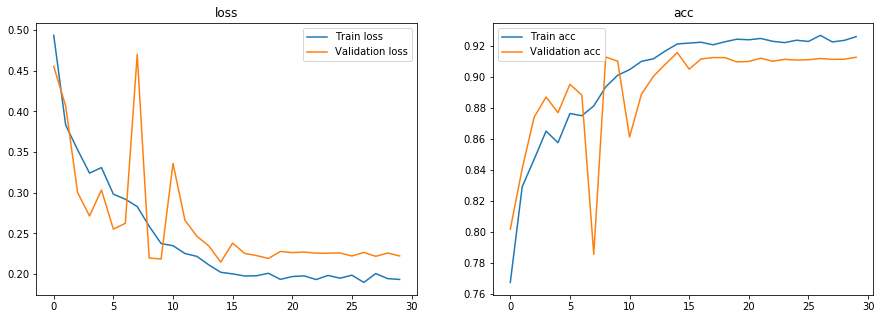

In [11]:
show_final_history(history)
print("Validation Accuracy: " + str(history.history['val_acc'][-1:]))

Found 24000 images belonging to 2 classes.
2400/2400 [==============================] - 101s 42ms/step


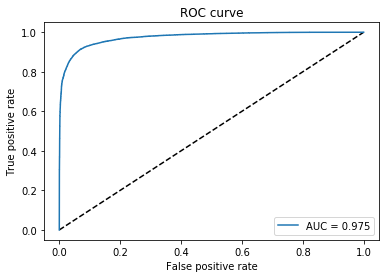

In [12]:
roc_validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                                  target_size=(96,96),
                                                                                  batch_size=10,
                                                                                  class_mode='binary',
                                                                                  shuffle=False)
predictions = model.predict_generator(roc_validation_generator, steps=len(roc_validation_generator), verbose=1)
false_positive_rate, true_positive_rate, threshold = roc_curve(roc_validation_generator.classes, predictions)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.show()

In [13]:
testing_files = glob(os.path.join(INPUT_DIR+'test/','*.tif'))
submission = pd.DataFrame()
for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
    data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
    data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[3].split(".")[0])
    data_frame['image'] = data_frame['path'].map(imread)
    images = np.stack(data_frame.image, axis=0)
    predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
    predictions = np.array(predicted_labels)
    data_frame['label'] = predictions
    submission = pd.concat([submission, data_frame[["id", "label"]]])
submission.to_csv(KAGGLE_SUBMISSION_FILE, index=False, header=True)